In [72]:


import warnings
warnings.filterwarnings("ignore")

%pip install -r requirements.txt
%pip install -U pip setuptools wheel
%pip install -U "spacy[apple]"
!python3 -m spacy download en_core_web_sm





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.2 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [73]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
import urllib3.exceptions
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", urllib3.exceptions.NotOpenSSLWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras

import re
import spacy

from collections import Counter

from tqdm import tqdm
tqdm.pandas()



# Part 1 - Data Processing

## 1.1 Loading the dataset & 1.2 Data Cleaning

In [74]:

def load_and_setup_data() -> pd.DataFrame:
    df = pd.read_csv("twitter_training.csv")    
    # First column appers to be some sort file or sequence number and the second appears to be the source
    # Those two columns do not have any impact on sentiment analysis
    # Take the last two columns
    df = df.iloc[:, -2:]
    # Swap columns 1 and 2
    df = df[[df.columns[1], df.columns[0]]]
    # Setup column names
    df.columns = ["tweet", "sentiment"]
    # Remove empty rows
    df = df.dropna()
    # Remove where sentiment is "Irrelevant"
    df = df[df["sentiment"] != "Irrelevant"]
    # Remove diuplicate rows
    df = df.drop_duplicates()
    # Look for tweets where the same tweet is classified as a different sentiment
    # Take the first occurence - this will get us clean data and will not mislead the classifier later during training
    df = df.drop_duplicates(subset=["tweet"], keep="first")
    return df

df = load_and_setup_data()


# Just keep the essentials, remove named entities, parsing and sentence segmentation for speed
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "senter"])


def clean_and_pre_process(texts: list[str]) -> list[str]:        
    url_pattern = re.compile(r"http\S+|www\S+|https\S+")
    twitter_handle_pattern = re.compile(r"\@\w+|\#")
    non_alpha_pattern = re.compile(r"[^a-zA-Z\s]")

    cleaned_texts: list[str] = []
    for text in texts:
        text = url_pattern.sub("", text)
        text = twitter_handle_pattern.sub("", text)
        text = non_alpha_pattern.sub("", text)
        cleaned_texts.append(text.strip().lower())

    docs = nlp.pipe(cleaned_texts, batch_size=2000, n_process=-1)

    final_texts: list[str] = []
    for doc in tqdm(docs, total=len(cleaned_texts)):
        # This is a key line - we are lemmatizing, removing stop words, punctuation and single character tokens
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_) > 1]
        final_texts.append(" ".join(tokens))

    return final_texts
    
    
df["sanitized_tweet"] = clean_and_pre_process(df["tweet"].tolist())
df.head()

100%|██████████| 57296/57296 [00:16<00:00, 3513.07it/s]


,tweet,sentiment,sanitized_tweet
0,I am coming to the borders and I will kill you...,Positive,come border kill
1,im getting on borderlands and i will kill you ...,Positive,get borderland kill
2,im coming on borderlands and i will murder you...,Positive,come borderland murder
3,im getting on borderlands 2 and i will murder ...,Positive,get borderland murder
4,im getting into borderlands and i can murder y...,Positive,get borderland murder


## 1.3 Feature Engineering

In [75]:
def create_tokenized_words(df: pd.DataFrame) -> pd.DataFrame:
    texts = df["sanitized_tweet"].values
    vectorizer = tf.keras.layers.TextVectorization(max_tokens=5000, output_mode="int", output_sequence_length=300)   
    vectorizer.adapt(texts)
    # Convert text to TF-IDF vectors
    tfidf_vectors = vectorizer(texts)
    # add the tokenized words as a new column
    df["sanitized_tweet_vector"] = list(tfidf_vectors.numpy())
    return df

df = create_tokenized_words(df)
df.head()

,tweet,sentiment,sanitized_tweet,sanitized_tweet_vector
0,I am coming to the borders and I will kill you...,Positive,come border kill,"[30, 1503, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,im getting on borderlands and i will kill you ...,Positive,get borderland kill,"[7, 49, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,im coming on borderlands and i will murder you...,Positive,come borderland murder,"[30, 49, 1108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,im getting on borderlands 2 and i will murder ...,Positive,get borderland murder,"[7, 49, 1108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,im getting into borderlands and i can murder y...,Positive,get borderland murder,"[7, 49, 1108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Part 2 - Exploratory Data Analysis (EDA)

## 2.1 Basic Statistics

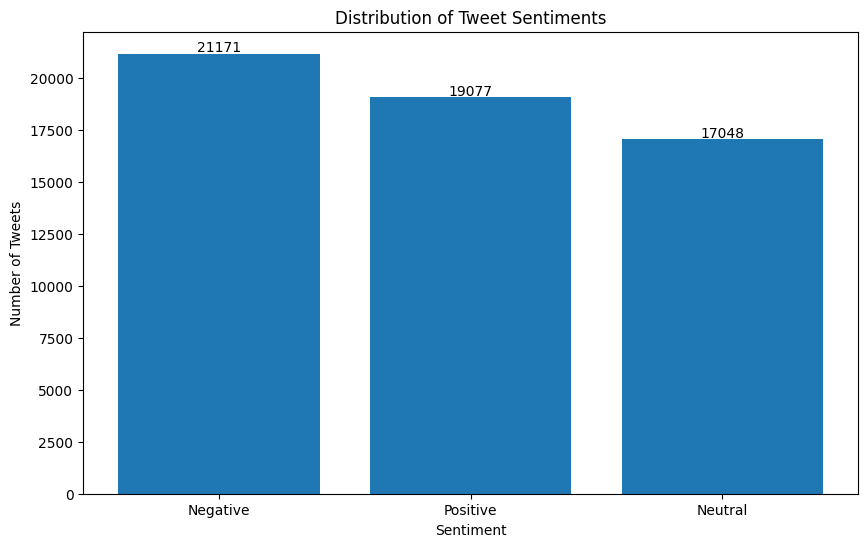

In [76]:
# Explore the distribution of tweet sentiments (e.g., how many positive, negative, and neutral tweets are there?).
# Plot a simple bar chart
sentiment_counts = df["sentiment"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values.tolist())
# Add total counts on top of each bar
for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 100, str(count), ha="center")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Sentiments")
plt.show()


## 2.2 Visualizations

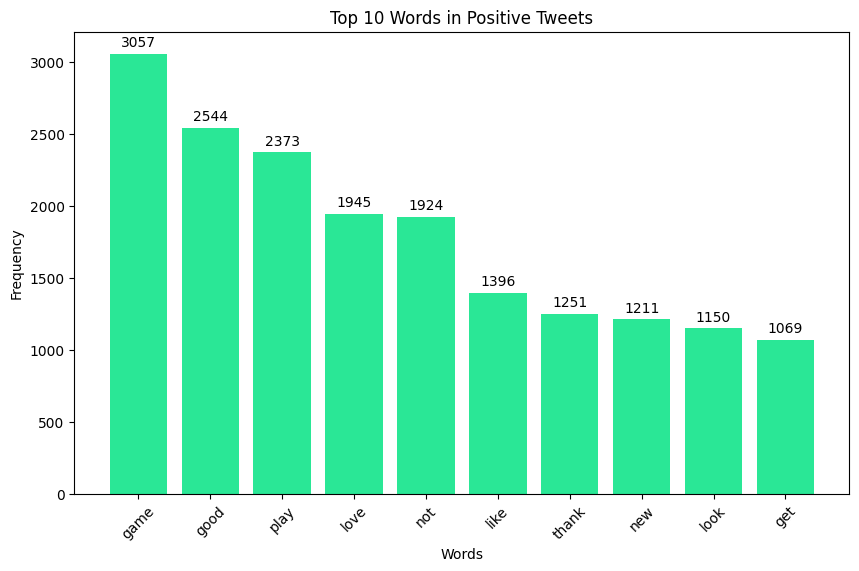

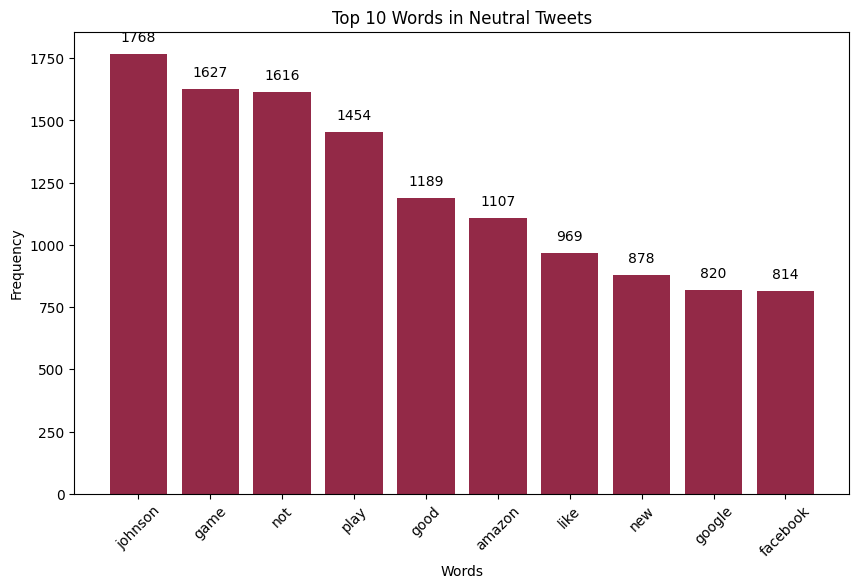

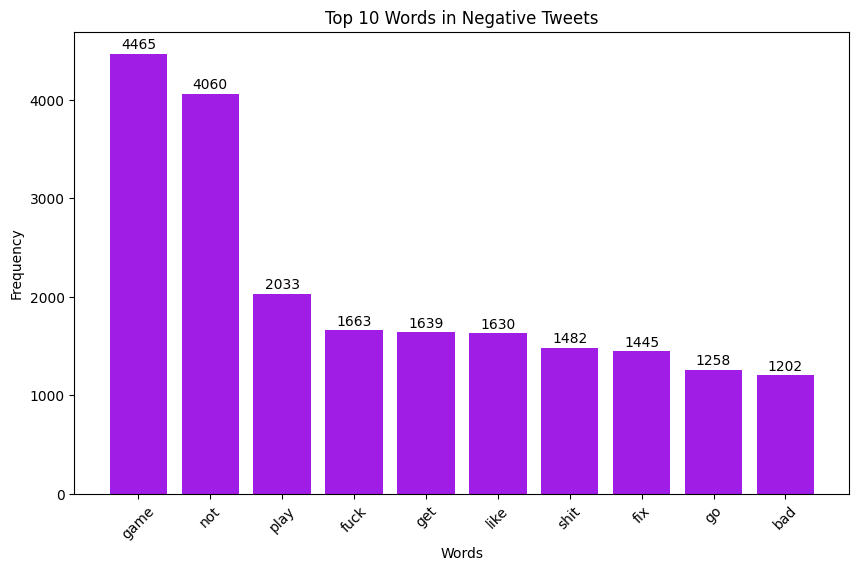

In [ ]:
# Frequency of top words in Positive, Negative and Neutral tweets

sentiment_categories = df["sentiment"].unique()


top_n = 10
for sentiment in sentiment_categories:
    subset = df[df["sentiment"] == sentiment]
    all_words = " ".join(subset["sanitized_tweet"]).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(top_n)    
    words, counts = zip(*most_common_words)    
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color = np.random.rand(3,))
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(f"Top {top_n} Words in {sentiment} Tweets")
    plt.xticks(rotation=45)
    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha="center")
    plt.show()

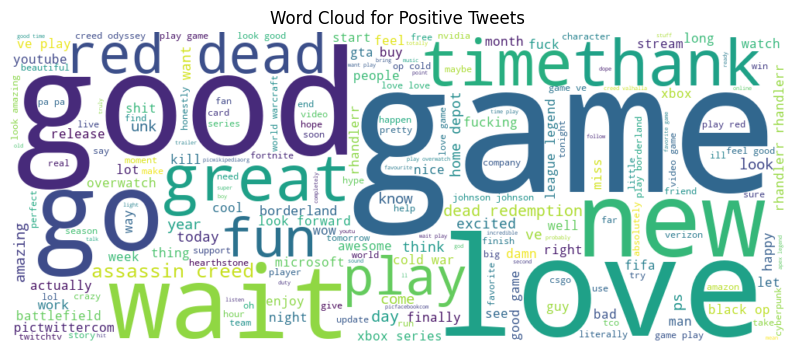

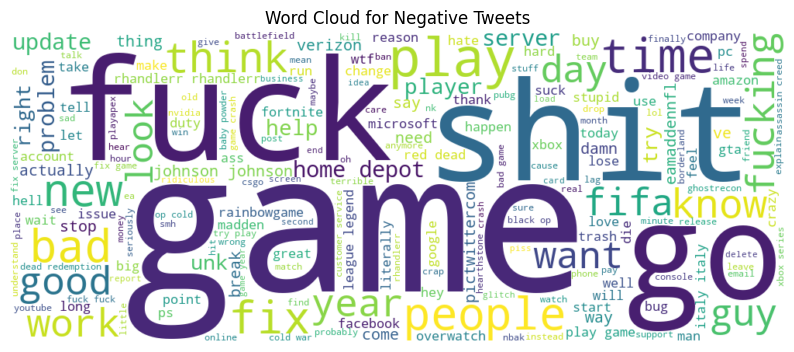

In [81]:
# Wordcloud for positive and negative tweets
for sentiment in ["Positive", "Negative"]:
    subset = df[df["sentiment"] == sentiment]
    all_words = " ".join(subset["sanitized_tweet"])
    wordcloud = WordCloud(width=1000, height=400, background_color="white").generate(all_words)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Tweets")
    plt.show()

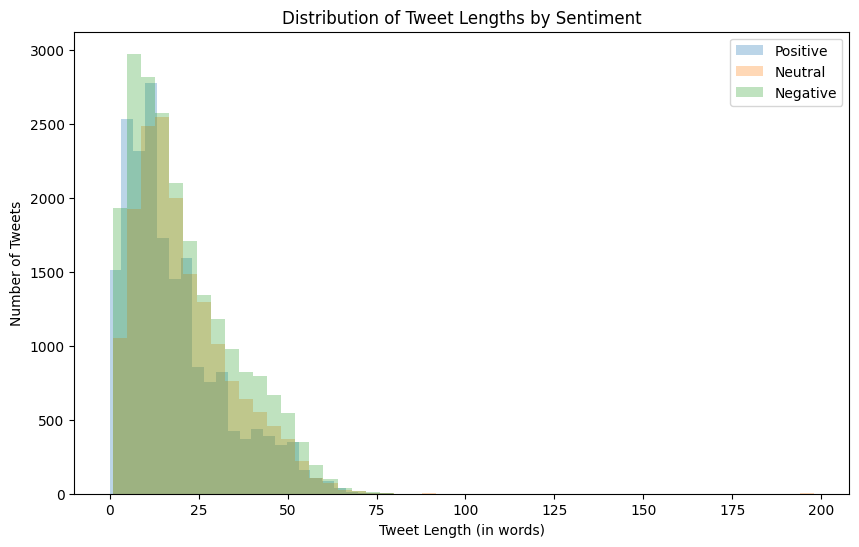

In [87]:
# Relationthip between tweet length and sentiment
df["tweet_length"] = df["tweet"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
for sentiment in sentiment_categories:
    subset = df[df["sentiment"] == sentiment]
    plt.hist(subset["tweet_length"], bins=50, alpha=0.3, label=sentiment)
plt.xlabel("Tweet Length (in words)")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Lengths by Sentiment")
plt.legend()
plt.show() 


## 2.3 Insights

* There is no distinct visble relationship between the length of a tweet and it's sentiment
* The words "game" & "play" are in top 10 for Positive, Negative and Neutral tweets
* Tweets cannot be classified based on just 1 or 2 words, we need to know the "Context" under which they are used